In [5]:
import numpy as np
import pandas as pd
import networkx as nx
import igraph as ig # Used for efficient Modularity and Global Efficiency
import powerlaw
import matplotlib.pyplot as plt

# --- Helper Function to Convert NetworkX to iGraph (for speed) ---
def nx_to_ig(G):
    """Converts a NetworkX graph to an igraph graph."""
    edges = [(u, v) for u, v in G.edges()]
    return ig.Graph(n=len(G.nodes), edges=edges, directed=False)

# --- Helper Function for Scale-Free Fit ---
def get_scale_free_fit(G):
    """
    Fits the degree distribution to a power-law and returns the goodness-of-fit (R-squared).
    Requires the 'powerlaw' package.
    """
    if G.number_of_nodes() < 5 or G.number_of_edges() == 0:
        return 0.0 # Return 0 for tiny/empty graphs

    degrees = [d for n, d in G.degree()]
    
    # Filter out degrees of 0 and only proceed if we have enough unique degrees
    non_zero_degrees = [d for d in degrees if d > 0]
    if len(set(non_zero_degrees)) < 5: 
        return 0.0
    
    try:
        # Fit the distribution. Use discrete=True for degree distributions.
        fit = powerlaw.Fit(non_zero_degrees, discrete=True, xmin=1) 
        
        # Powerlaw package doesn't directly give R^2, so we use the 
        # R value from the power_law_gamma fit on the complementary cumulative distribution.
        # This is a common, though not perfect, proxy for goodness-of-fit in this context.
        # A more robust approach uses log-likelihood ratio (R, p-value from fit.distribution_compare)
        # but R^2 is often preferred for visual inspection.
        # We will use the R from the linear fit of the log-log plot as a simpler proxy for R^2:
        # Log-log linear regression slope and R^2 on the CCDF for the visible power-law region.
        
        # For simplicity and robustness, we will use the likelihood ratio test outcome 
        # (R, p) vs. a competing distribution (e.g., exponential).
        R, p = fit.distribution_compare('power_law', 'exponential')
        
        # If R > 0 and p < 0.1, power-law is likely better than exponential. 
        # Let's use R as a proxy for 'fit strength' relative to exponential.
        # A positive R means power-law is a better fit.
        return R 
        
    except Exception as e:
        # Handle cases where the powerlaw fit fails (e.g., too few data points)
        return 0.0

In [6]:
def analyze_network_cutoffs(interaction_matrix, cutoff_range=np.arange(0.1, 1.0, 0.05)):
    """
    Iterates over cutoffs, builds networks, and calculates key topology metrics.

    :param interaction_matrix: Square numpy array of pairwise interactions (-1 to +1).
    :param cutoff_range: A list/array of absolute correlation thresholds to test.
    :return: DataFrame with cutoff and corresponding metrics.
    """
    results = []
    
    # 1. Apply absolute value to focus on interaction strength
    abs_matrix = np.abs(interaction_matrix)

    for C in cutoff_range:
        # 2. Threshold the matrix: 1 if |interaction| >= C, else 0
        adj_matrix = (abs_matrix >= C).astype(int)

        # 3. Create the NetworkX graph
        G_nx = nx.from_numpy_array(adj_matrix)
        
        # Remove self-loops (should be zero, but good practice) and isolated nodes
        G_nx.remove_edges_from(nx.selfloop_edges(G_nx))
        G_nx.remove_nodes_from(list(nx.isolates(G_nx)))

        N_nodes = G_nx.number_of_nodes()
        N_edges = G_nx.number_of_edges()

        if N_edges == 0 or N_nodes < 3:
            # Skip analysis if the network is too sparse
            results.append({
                'Cutoff': C,
                'Nodes': N_nodes,
                'Edges': N_edges,
                'Density': 0.0,
                'Modularity': 0.0,
                'Global_Efficiency': 0.0,
                'Scale_Free_R_vs_Exp': 0.0
            })
            continue
        
        # --- Metric Calculation (iGraph for speed) ---
        # The igraph library is generally much faster for these metrics
        G_ig = nx_to_ig(G_nx)
        
        # A. Modularity
        # Use a community detection algorithm like Louvain to find modules
        community = G_ig.community_leiden() # or community_multilevel() / community_label_propagation()
        modularity = community.modularity if community else 0.0

        # B. Global Efficiency
        # Defined as the inverse of the average shortest path length
        # Using 1/L_avg. If disconnected, igraph handles this by ignoring infinite paths.
        try:
            # Efficiency is often a more robust metric than Avg Path Length for disconnected graphs
            global_efficiency = G_ig.efficiency()
        except:
            global_efficiency = 0.0
            
        # C. Scale-Free Fit (using the helper function)
        scale_free_R = get_scale_free_fit(G_nx)
        
        # D. Density
        density = nx.density(G_nx)

        results.append({
            'Cutoff': C,
            'Nodes': N_nodes,
            'Edges': N_edges,
            'Density': density,
            'Modularity': modularity,
            'Global_Efficiency': global_efficiency,
            'Scale_Free_R_vs_Exp': scale_free_R
        })

    return pd.DataFrame(results).set_index('Cutoff')

In [ ]:
--- 4. Example: Generate Sample Data and Run Analysis ---

# Create a synthetic interaction matrix (e.g., a correlation matrix)
N = 100 # Number of nodes
np.random.seed(42)
# Random values between -1 and 1
interaction_values = np.random.uniform(-1, 1, size=(N, N)) 
# Make it symmetric and set diagonal to 1 (like a correlation matrix)
interaction_matrix = (interaction_values + interaction_values.T) / 2
np.fill_diagonal(interaction_matrix, 1.0) 

# Define the cutoffs to test
test_cutoffs = np.linspace(0.05, 0.95, 20)

# Run the analysis
df_results = analyze_network_cutoffs(interaction_matrix, cutoff_range=test_cutoffs)

print("--- Analysis Results ---")
print(df_results.head(10))

# --- 5. Plotting Results ---
plt.figure(figsize=(12, 8))

# Plot 1: Modularity
plt.subplot(2, 2, 1)
df_results['Modularity'].plot(marker='o', color='b')
plt.title('A. Modularity vs. Cutoff')
plt.ylabel('Modularity (Max $Q$)')
plt.xlabel('Cutoff ($|r|$)')
plt.grid(True, linestyle='--', alpha=0.6)

# Plot 2: Global Efficiency
plt.subplot(2, 2, 2)
df_results['Global_Efficiency'].plot(marker='o', color='g')
plt.title('B. Global Efficiency vs. Cutoff')
plt.ylabel('Global Efficiency')
plt.xlabel('Cutoff ($|r|$)')
plt.grid(True, linestyle='--', alpha=0.6)

# Plot 3: Scale-Free Fit (R from Power-Law vs. Exponential Likelihood Ratio)
plt.subplot(2, 2, 3)
df_results['Scale_Free_R_vs_Exp'].plot(marker='o', color='r')
plt.title('C. Scale-Free Fit vs. Cutoff')
plt.ylabel('Power-Law Likelihood Ratio (vs. Exp)')
plt.xlabel('Cutoff ($|r|$)')
plt.axhline(0, color='grey', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.6)

# Plot 4: Network Density/Sparsity
plt.subplot(2, 2, 4)
df_results['Density'].plot(marker='o', color='k')
plt.title('D. Network Density vs. Cutoff')
plt.ylabel('Density')
plt.xlabel('Cutoff ($|r|$)')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [7]:
import pandas as pd

df = pd.read_csv("/mnt/c/Users/sauba/Desktop/20.RERConverge_trimmed/3.New_colias/61.New_alignment_colias/2.ERC_plot/ERC_correlation_full_longform.csv")
print(df.head())

         Gene1        Gene2     value
0  10716at7088  10716at7088  1.000000
1  10716at7088   2679at7088  0.229918
2  10716at7088  10214at7088  0.174992
3  10716at7088   1571at7088  0.062789
4  10716at7088  14278at7088  0.068689


In [20]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

cutoffs = np.arange(0.15, 0.95, 0.05)
metrics = []

for cutoff in cutoffs:
    print(cutoff)
    # Filter edges above cutoff
    edges = df[df["value"] >= cutoff][["Gene1", "Gene2", "value"]]
    G = nx.from_pandas_edgelist(edges, "Gene1", "Gene2", edge_attr="value")
    
    if G.number_of_edges() == 0:
        metrics.append((cutoff, 0, 0, 0))
        continue
    
    print("Compute key metrics")
    density = nx.density(G)
    giant_component = len(max(nx.connected_components(G), key=len)) / G.number_of_nodes()
    clustering = nx.average_clustering(G)
    
    metrics.append((cutoff, density, giant_component, clustering))

metrics_df = pd.DataFrame(metrics, columns=["cutoff", "density", "giant_component", "clustering"])

0.15
Compute key metrics
0.2
Compute key metrics
0.25
Compute key metrics
0.30000000000000004
Compute key metrics
0.3500000000000001
Compute key metrics
0.40000000000000013
Compute key metrics
0.45000000000000007
Compute key metrics
0.5000000000000001
Compute key metrics
0.5500000000000002
Compute key metrics
0.6000000000000002
Compute key metrics
0.6500000000000002
Compute key metrics
0.7000000000000002
Compute key metrics
0.7500000000000002
Compute key metrics
0.8000000000000003
Compute key metrics
0.8500000000000002
Compute key metrics
0.9000000000000002
Compute key metrics


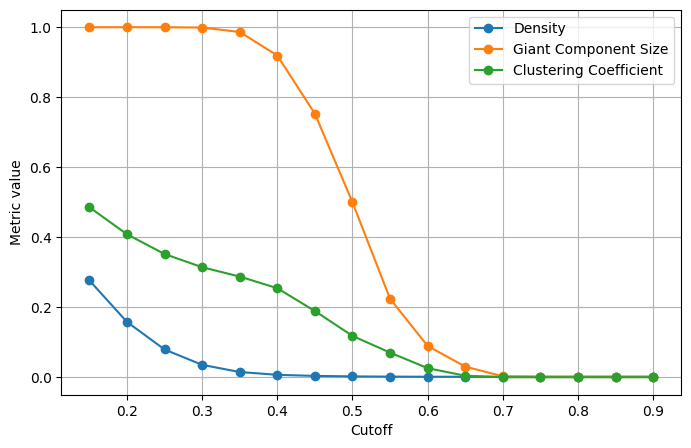

In [22]:
plt.figure(figsize=(8,5))
plt.plot(metrics_df["cutoff"], metrics_df["density"], "-o", label="Density")
plt.plot(metrics_df["cutoff"], metrics_df["giant_component"], "-o", label="Giant Component Size")
plt.plot(metrics_df["cutoff"], metrics_df["clustering"], "-o", label="Clustering Coefficient")
plt.xlabel("Cutoff")
plt.ylabel("Metric value")
plt.legend()
plt.grid(True)
plt.show()

0.2
0.25
0.3
0.35
0.39999999999999997
0.44999999999999996
0.49999999999999994
0.5499999999999999
0.5999999999999999
0.6499999999999999
0.7
0.7499999999999998
0.7999999999999998
0.8499999999999999
0.8999999999999999
    cutoff  n_nodes  n_edges   density  giant_fraction  clustering
0     0.20     4571  1647706  0.157755        1.000000    0.408329
1     0.25     4571   827395  0.079216        1.000000    0.351920
2     0.30     4568   368438  0.035321        0.999124    0.314261
3     0.35     4476   148782  0.014856        0.986372    0.287536
4     0.40     4021    55232  0.006834        0.919174    0.254259
5     0.45     3234    19707  0.003770        0.752628    0.188977
6     0.50     2451     7143  0.002379        0.499796    0.118046
7     0.55     1897     3060  0.001702        0.224038    0.070281
8     0.60     1611     1795  0.001384        0.089385    0.025942
9     0.65     1486     1492  0.001352        0.030283    0.004218
10    0.70     1444     1438  0.001380        0.

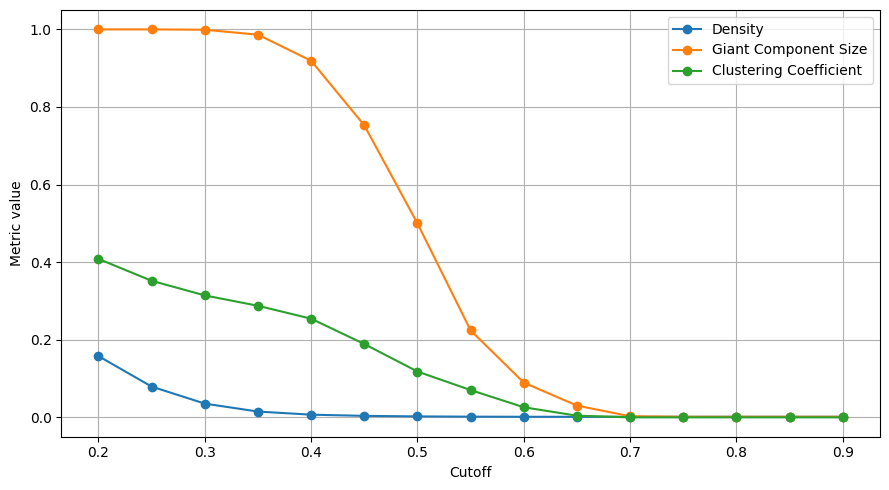

Suggested cutoffs: {'max_drop_before': 0.6499999999999999, 'max_drop_after': 0.7, '<=50%_first': 0.49999999999999994}
Found 1 clusters with size >= 3 at cutoff 0.6499999999999999
1 45 ['1065at7088', '1076at7088', '10778at7088', '1114at7088', '1154at7088', '1246at7088', '1300at7088', '1459at7088']


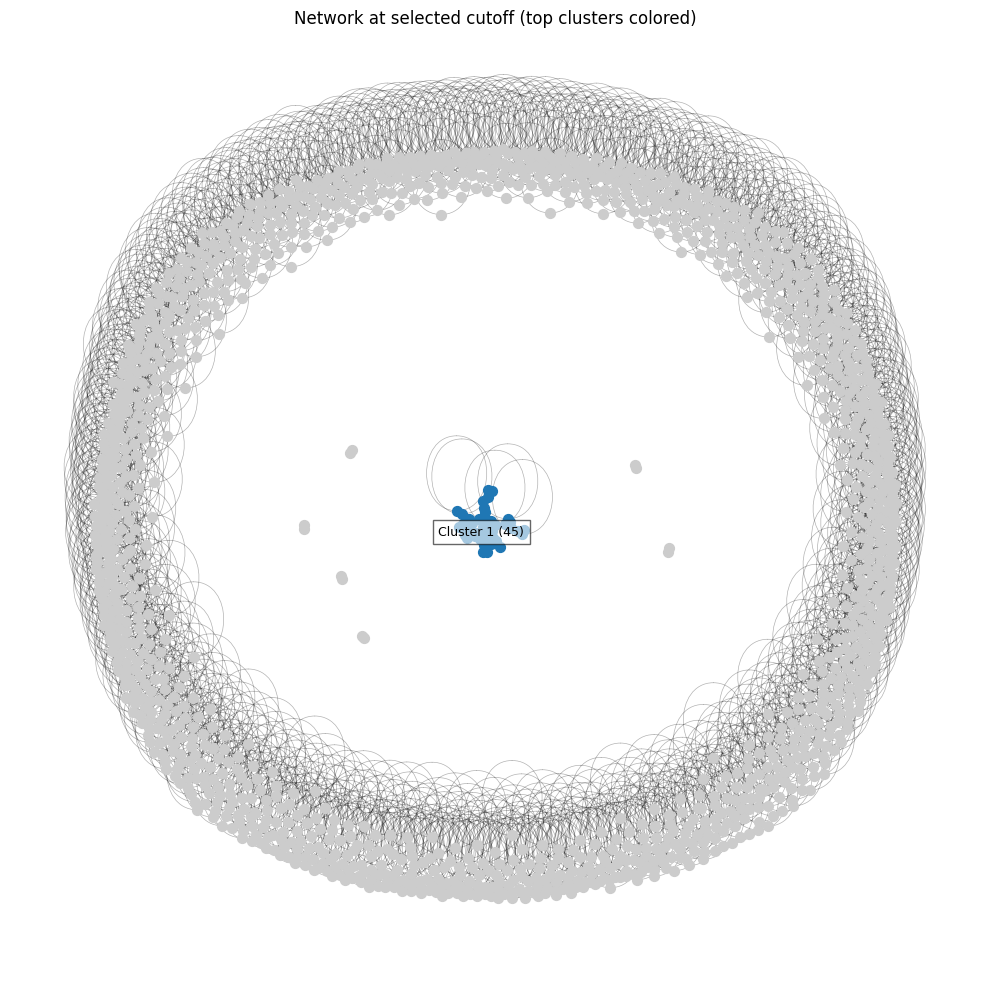

In [19]:
# Required packages:
# pip install networkx pandas numpy matplotlib gseapy python-igraph leidenalg  # optional
# pip install goatools  # optional for GO enrichment

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

def compute_metrics(df, cutoffs=None):
    if cutoffs is None:
        cutoffs = np.arange(0.2, 0.95, 0.05)
    records = []
    for cutoff in cutoffs:
        print(cutoff)
        edges = df[df["value"] >= cutoff][["Gene1", "Gene2", "value"]]
        G = nx.from_pandas_edgelist(edges, "Gene1", "Gene2", edge_attr="value")
        n_nodes = G.number_of_nodes()
        n_edges = G.number_of_edges()
        if n_nodes <= 1 or n_edges == 0:
            records.append((cutoff, n_nodes, n_edges, 0.0, 0.0, 0.0))
            continue
        density = nx.density(G)
        comps = list(nx.connected_components(G))
        largest = len(max(comps, key=len))
        giant_frac = largest / n_nodes
        clustering = nx.average_clustering(G) if n_edges > 1 else 0.0
        records.append((cutoff, n_nodes, n_edges, density, giant_frac, clustering))
    metrics_df = pd.DataFrame(records, columns=[
        "cutoff", "n_nodes", "n_edges", "density", "giant_fraction", "clustering"
    ])
    return metrics_df

def detect_threshold(metrics_df, method="max_drop"):
    """
    method:
      - "max_drop": find largest drop in giant_fraction between consecutive cutoffs,
                    return the cutoff *before* the drop (i.e. conservatively keep edges).
      - "50percent": find first cutoff where giant_fraction <= 0.5
      - "combo": returns both suggestions
    """
    suggestions = {}
    gf = metrics_df["giant_fraction"].values
    cutoffs = metrics_df["cutoff"].values

    # compute fractional decreases between consecutive points
    diffs = gf[:-1] - gf[1:]
    relative_drops = np.zeros_like(diffs)
    with np.errstate(divide='ignore', invalid='ignore'):
        relative_drops = np.where(gf[:-1] > 0, diffs / gf[:-1], 0)

    if method in ("max_drop", "combo"):
        if len(relative_drops) > 0:
            idx = np.argmax(relative_drops)
            # choose the cutoff *just before* the large drop (safer)
            suggested_cutoff_before = cutoffs[max(0, idx)]
            suggested_cutoff_after = cutoffs[min(len(cutoffs)-1, idx+1)]
            suggestions["max_drop_before"] = suggested_cutoff_before
            suggestions["max_drop_after"] = suggested_cutoff_after

    if method in ("50percent", "combo"):
        leq50 = metrics_df[metrics_df["giant_fraction"] <= 0.5]
        if not leq50.empty:
            suggestions["<=50%_first"] = float(leq50.iloc[0]["cutoff"])
        else:
            suggestions["<=50%_first"] = None

    return suggestions

def extract_clusters_at_cutoff(df, cutoff, min_cluster_size=3):
    edges = df[df["value"] >= cutoff][["Gene1", "Gene2", "value"]]
    G = nx.from_pandas_edgelist(edges, "Gene1", "Gene2", edge_attr="value")
    comps = sorted(nx.connected_components(G), key=len, reverse=True)
    clusters = [sorted(list(c)) for c in comps if len(c) >= min_cluster_size]
    # also return singleton and small components if needed
    small = [sorted(list(c)) for c in comps if 1 < len(c) < min_cluster_size]
    singletons = [list(c)[0] for c in comps if len(c) == 1]
    return G, clusters, small, singletons

def plot_metrics(metrics_df, figsize=(9,5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(metrics_df.cutoff, metrics_df.density, '-o', label="Density")
    ax.plot(metrics_df.cutoff, metrics_df.giant_fraction, '-o', label="Giant Component Size")
    ax.plot(metrics_df.cutoff, metrics_df.clustering, '-o', label="Clustering Coefficient")
    ax.set_xlabel("Cutoff")
    ax.set_ylabel("Metric value")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    return fig, ax

def visualize_clusters(G, clusters, top_n=6, node_size=50, figsize=(10,10), seed=42):
    """
    Draw graph with cluster coloring. clusters is a list of lists (gene names).
    We'll color the top_n largest clusters and gray-out the rest.
    """
    # map node -> cluster id (0..)
    node_cluster = {}
    for i, cl in enumerate(clusters[:top_n]):
        for node in cl:
            node_cluster[node] = i
    default_cluster = -1

    pos = nx.spring_layout(G, seed=seed)  # layout once

    # prepare coloring
    cmap = plt.get_cmap("tab20")
    fig, ax = plt.subplots(figsize=figsize)
    for node in G.nodes():
        cid = node_cluster.get(node, default_cluster)
        color = cmap(cid % 20) if cid >= 0 else (0.8,0.8,0.8)  # gray for unassigned
        nx.draw_networkx_nodes(G, pos, nodelist=[node], node_size=node_size, node_color=[color], ax=ax)
    # draw edges (thin)
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5, ax=ax)
    # annotate cluster leaders (largest nodes) for clarity
    for i, cl in enumerate(clusters[:top_n]):
        # pick central node to label (highest degree)
        sub = G.subgraph(cl)
        if sub.number_of_nodes() == 0: 
            continue
        degrees = dict(sub.degree())
        leader = max(degrees, key=degrees.get)
        ax.text(pos[leader][0], pos[leader][1], f"Cluster {i+1} ({len(cl)})",
                fontsize=9, bbox=dict(facecolor='white', alpha=0.6), ha='center', va='center')
    ax.set_title("Network at selected cutoff (top clusters colored)")
    ax.axis('off')
    plt.tight_layout()
    return fig, ax

# -------------------------
# Example usage (run this block):
# -------------------------
# df should be your dataframe with 'Gene1','Gene2','value'

metrics_df = compute_metrics(df)
print(metrics_df)
fig, ax = plot_metrics(metrics_df)
plt.show()

# detection:
suggestions = detect_threshold(metrics_df, method="combo")
print("Suggested cutoffs:", suggestions)

# pick cutoff (for example, take the 'max_drop_before' suggestion)
chosen_cutoff = suggestions.get("max_drop_before") or 0.5

G, clusters, small, singletons = extract_clusters_at_cutoff(df, chosen_cutoff)
print(f"Found {len(clusters)} clusters with size >= 3 at cutoff {chosen_cutoff}")
for i, cl in enumerate(clusters[:10]):
    print(i+1, len(cl), cl[:8])

fig, ax = visualize_clusters(G, clusters, top_n=8)
plt.show()
